In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import proplot as pplt
from scipy.fftpack import * 

## rainday rain intensity

2021.08.09

绘制rainday 以及 rain intensity 等日降水指标,需要修正一下rainday的数据选取，为什么按照RCM的nan进行了MASK

In [2]:
dir_in = "/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA_large/pre/ordata/"
filename_obs  = "obsmerge_pre_98-17.nc"
filename_vr     = "vr_pre_98-17.nc"
filename_rcm    = "rcm_pre_98-17.nc"

ds_or = {}
ds_or['obs'] = xr.open_dataset(dir_in + filename_obs)
ds_or['vr']     = xr.open_dataset(dir_in + filename_vr)
ds_or['rcm']    = xr.open_dataset(dir_in + filename_rcm  )
# 提取变量
var = {}
var['obs'] = ds_or['obs']['premerge']#[:,  :, :]
var['vr'] = ds_or['vr']['precip_MPAS']
var['rcm'] = ds_or['rcm']['precip_MPAS']

var['obs'] = var['obs'].reset_coords(names = 'lev', drop = True) # 去除掉obs中多余的lev coords

# change coords
var_list = ['obs', 'vr', 'rcm']
for i in var_list:
    rename_dict = dict(zip(var[i].coords.keys(), var['obs'].coords.keys()))
#     # show converting coords
    for rename_i in rename_dict:
        print(rename_i + " -----converting to----- " + rename_dict[rename_i])

    var[i] = var[i].rename(rename_dict)
    var[i]._coords = var['obs']._coords
    var[i] = var[i].rename(i)


time -----converting to----- time
lon -----converting to----- lon
lat -----converting to----- lat
Time -----converting to----- time
longitude -----converting to----- lon
latitude -----converting to----- lat
Time -----converting to----- time
longitude -----converting to----- lon
latitude -----converting to----- lat


## 计算rainday 以及 rain intensity

In [5]:
var_index = {}

time_idx = {}
time_idx['am'] = var['obs'].time.dt.month.isin([4,5])
time_idx['jja'] = var['obs'].time.dt.month.isin([6,7,8])

for mod_name in ['obs', 'vr', 'rcm']:
    var_index[mod_name] = {}
    for iseason in ['am','jja']:
        var_index[mod_name][iseason] = {}
        var_selmonth = var[mod_name].isel(time = time_idx[iseason]) # 选取月份的mod变量，后续通过它计算指标
        rainday_cond   = (var_selmonth>0.1)
        var_index[mod_name][iseason]['rainday'] = xr.where(rainday_cond, 1., 0.)# 降水日，需要进行累加
        var_index[mod_name][iseason]['rainday_filter'] = xr.where(rainday_cond, var_selmonth, np.nan)# rainday 的降水强度
        var_index[mod_name][iseason]['quantile_95'] =  var_selmonth.quantile(0.95, dim='time') # 95% 分位数的位置


/m2data2/yycheng/anaconda3/envs/proplot0528/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


In [11]:
# 计算指数的平均值
var_index_mean = {}
month_in_season = {}
month_in_season['am'] = 1220. / 30 # var_index[mod_name][iseason]['rainday'].shape[0]
month_in_season['jja'] = 1840. / 30 # 计算30天内的rainday的频率用

rcm_not_nan = ~np.isnan(var['rcm'][0,:,:]) # 添加新的nan，rainday经过计算后nan消失

for mod_name in ['obs', 'vr', 'rcm']:
    var_index_mean[mod_name] = {}
    for iseason in ['am','jja']:
        var_index_mean[mod_name][iseason] = {}
        var_index_mean[mod_name][iseason]['rainday'] = var_index[mod_name][iseason]['rainday'].sum(dim = 'time') / month_in_season[iseason]
        # var_index_mean[mod_name][iseason]['rainday'] = xr.where(rcm_not_nan, var_index_mean[mod_name][iseason]['rainday'], np.nan)
        var_index_mean[mod_name][iseason]['rainday_filter'] = var_index[mod_name][iseason]['rainday_filter'].mean(dim = 'time')

var_index_mean['rcm']['am']['rainday'] = xr.where(~np.isnan(var_selmonth[0,:,:]), var_index_mean[mod_name][iseason]['rainday'], np.nan) # 添加NAN mask
var_index_mean['rcm']['jja']['rainday'] = xr.where(~np.isnan(var_selmonth[0,:,:]), var_index_mean[mod_name][iseason]['rainday'], np.nan) # 添加NAN mask

## 绘图部分

#### 2021.08.30 renew
挑选长江黄河进行绘制

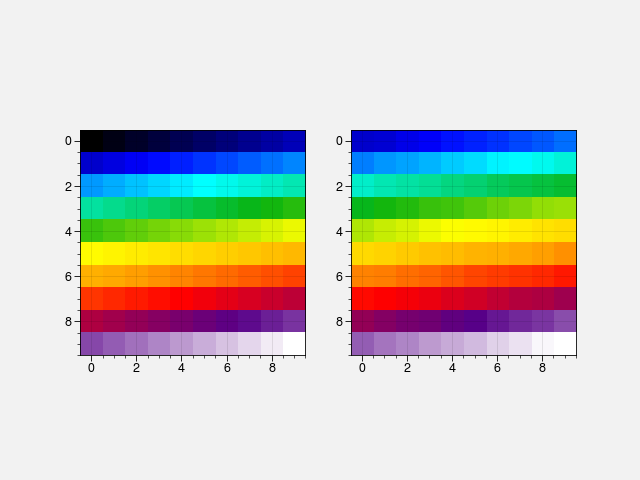

In [7]:
# 调整cmap，去掉gist_ncar 中深蓝色的部分
# https://stackoverflow.com/questions/18926031/how-to-extract-a-subset-of-a-colormap-as-a-new-colormap-in-matplotlib
import cmaps
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

arr = np.linspace(0, 50, 100).reshape((10, 10))
fig, ax = plt.subplots(ncols=2)

# cmap = plt.get_cmap('gist_ncar')
cmap = cmaps.BkBlAqGrYeOrReViWh200
new_cmap = truncate_colormap(cmap, 0.1, 1.)
ax[0].imshow(arr, interpolation='nearest', cmap=cmap)
ax[1].imshow(arr, interpolation='nearest', cmap=new_cmap)
plt.show()

In [8]:
## 地图绘制预备数据
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches

In [9]:
# 查看数据范围 测试ticks
# rainday_ticks = np.concatenate((np.array([0,10]), np.linspace(12,30,19)), axis=0)
# rainday_ticks
# intensity_ticks = np.concatenate((np.linspace(0,15,16), np.linspace(18,30,5)), axis=0)
# intensity_ticks
# var_index['obs']['am']['quantile_95'].min() # 0 - 75
quantile_ticks = np.concatenate(([10,20],np.linspace(25,55,16),[60,70,80]), axis=0)
# quantile_ticks = np.linspace(0,80,17)
quantile_ticks

array([10., 20., 25., 27., 29., 31., 33., 35., 37., 39., 41., 43., 45.,
       47., 49., 51., 53., 55., 60., 70., 80.])

----- tick levels is : [ 0. 10. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27.
 28. 29. 30.]


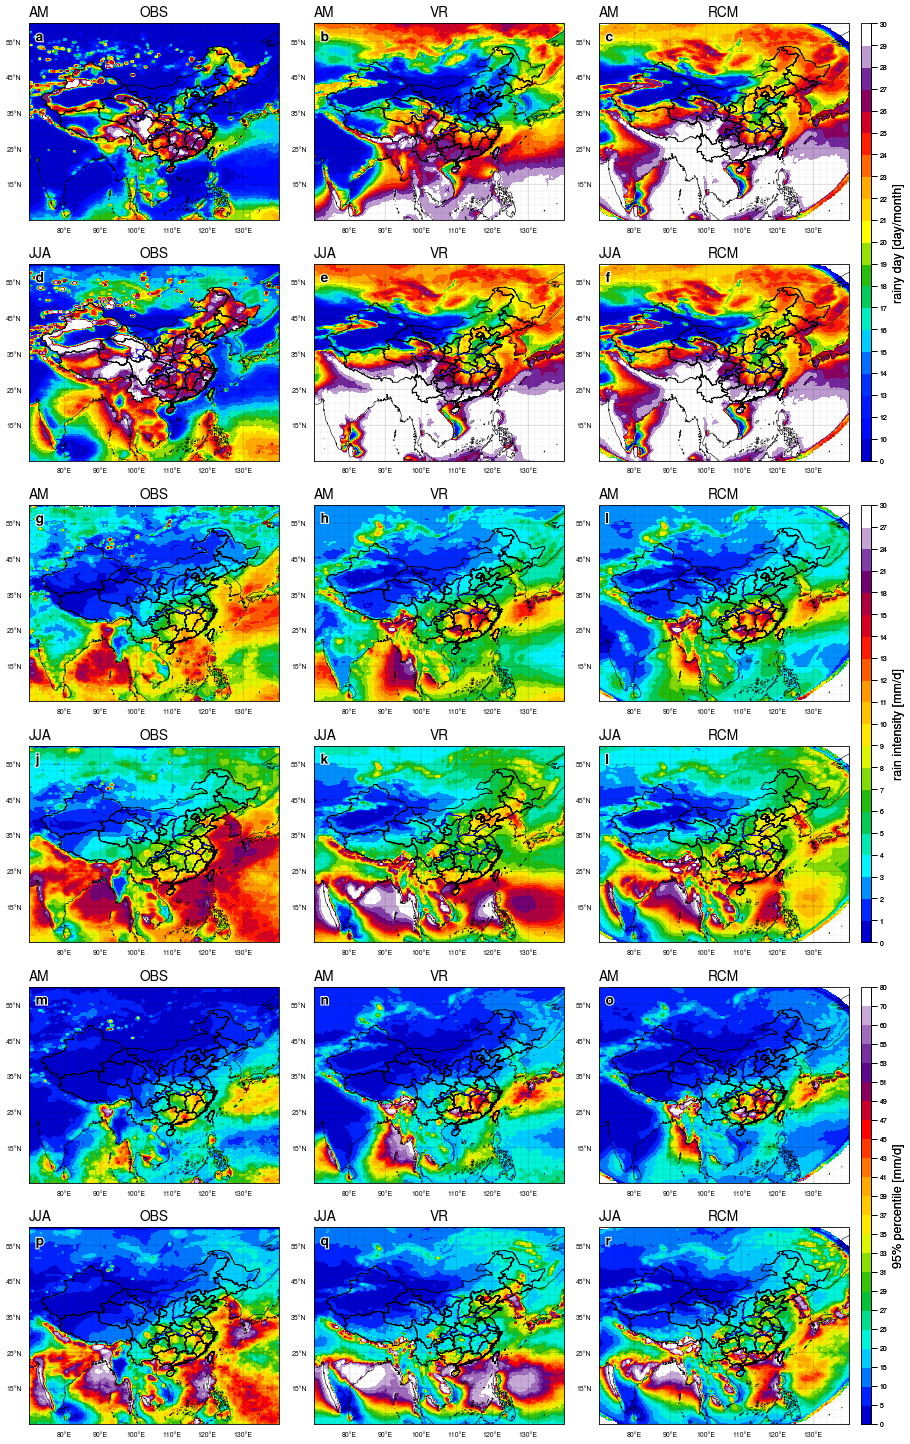

In [15]:
# import proplot as plot
from matplotlib import pyplot as plt
import proplot as plot
# ----- get filter vars coords-----

lon = var_index_mean['obs']['am']['rainday'].lon.values
lat = var_index_mean['obs']['am']['rainday'].lat.values

#----- create plot -----
fig, axs = plot.subplots(ncols=3 ,nrows=6, proj=('cyl'))
m_contour_list = [] # 用于保存contour设置，后续设置colorbar使用

#----- 添加海洋以及行政区划 -----

##---- 直接绘图，从边界文件添加
# for ax_ind in axs:
# for line in borders:
#     axs.plot(line[0::100], line[1::100], lw = 0.5, color='gray',transform=ccrs.Geodetic())
#     axs.plot(line[0::10], line[1::10], lw = 0.4, color='black',transform=ccrs.Geodetic())
##---- 使用shp文件添加
    # shapefile数据下载的位置：
# http://gaohr.win/site/blogs/2017/2017-04-18-GIS-basic-data-of-China.html
world_border_shapefile = "/m2data2/yycheng/data_stage/CN-border/World/country.shp"
river_border_shapefile =  "/raid52/yycheng/MPAS/REFERENCE/MODEL_CONSTANT/R1/" + "hyd1_4l.shp"
southsea_shapefile     = "/m2data2/yycheng/data_stage/CN-border/SouthSea/" + "southsea_island.shp"
ninelines_shapefile     = "/m2data2/yycheng/data_stage/CN-border/SouthSea/" + "nine_lines.shp"
## 来源： 沛沛的诸省 + 诸岛
bou24p_shapefile     = "/m2data2/yycheng/data_stage/CN-border/peipeihelp/" + "bou2_4p.shp"
## 来源： https://www.resdc.cn/data.aspx?DATAID=200
province_shapefile     = "/m2data2/yycheng/data_stage/CN-border/CN-sheng/" + "change_proj_CN-sheng-A.shp"

for ax in axs:
    # world     = shpreader.Reader(world_border_shapefile).geometries()
    # river     = shpreader.Reader(river_border_shapefile).geometries()
    river     = shpreader.Reader(river_border_shapefile, encoding = "gbk")
    # bou24p    = shpreader.Reader(bou24p_shapefile).geometries()
    ninelines = shpreader.Reader(ninelines_shapefile).geometries()
    province  = shpreader.Reader(province_shapefile).geometries()
    # ax.add_geometries(river, ccrs.PlateCarree(), facecolor='none', edgecolor='b', linewidth=0.4, zorder=1)
    # ax.add_geometries(world, ccrs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=0.4, zorder=1)
    # ax.add_geometries(bou24p, ccrs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=0.6, zorder=1) # 沛沛map
    ax.add_geometries(province, ccrs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=0.6, zorder=1) # 地资所
    ax.add_geometries(ninelines, ccrs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=0.6, zorder=1)
    # 绘制部分的shapefile
    for region in river.records():
        if (region.attributes['NAME'] in ['黄河','长江']):
            # print("----- draw river! -----")
            # 此处需要使用 [] 让region.geometry可以迭代
            ax.add_geometries([region.geometry], ccrs.PlateCarree(), facecolor='none', edgecolor='b', linewidth=0.4, zorder=1)

#----- colorbar ticks 统一设置 -----
# cmap = 'gist_ncar'
cmap = new_cmap
# cmap = cmap_data

rainday_ticks = np.concatenate((np.array([0,10]), np.linspace(12,30,19)), axis=0)
intensity_ticks = np.concatenate((np.linspace(0,15,16), np.linspace(18,30,5)), axis=0)
# quantile_ticks = np.linspace(0,80,17)
quantile_ticks = np.concatenate(([0,5,10,15,20],np.linspace(25,55,16),[60,70,80]), axis=0)

# rainday_ticks = np.linspace(10,30,11)
print("----- tick levels is : " + str(rainday_ticks))

# plot contourf and titile axs
axs[0,:].format(ltitle = 'AM')
axs[2,:].format(ltitle = 'AM')
axs[4,:].format(ltitle = 'AM')
axs[1,:].format(ltitle = 'JJA')
axs[3,:].format(ltitle = 'JJA')
axs[5,:].format(ltitle = 'JJA')

axs[:,0].format(title='OBS')
# axs[].format(title='OBS')
axs[:,1].format(title='VR')
# axs[4].format(title='VR')
axs[:,2].format(title='RCM')
# axs[5].format(title='RCM')

# axs[0:7].format(rtitle = )

for mod_ind, mod_name in enumerate(['obs','vr','rcm']):
    m_rainday = axs[mod_ind].contourf(lon, lat, var_index_mean[mod_name]['am']['rainday'].values,\
    levels=rainday_ticks,cmap=cmap)

    m_rainday = axs[mod_ind+3].contourf(lon, lat, var_index_mean[mod_name]['jja']['rainday'].values,\
    levels=rainday_ticks,cmap=cmap)
    
    m_intensity = axs[mod_ind+6].contourf(lon, lat, var_index_mean[mod_name]['am']['rainday_filter'].values,\
    levels=intensity_ticks,cmap=cmap)

    m_intensity = axs[mod_ind+9].contourf(lon, lat, var_index_mean[mod_name]['jja']['rainday_filter'].values,\
    levels=intensity_ticks,cmap=cmap)

    m_quantile = axs[mod_ind+12].contourf(lon, lat, var_index[mod_name]['am']['quantile_95'].values,\
    levels=quantile_ticks,cmap=cmap)

    m_quantile = axs[mod_ind+15].contourf(lon, lat, var_index[mod_name]['jja']['quantile_95'].values,\
    levels=quantile_ticks,cmap=cmap)


#----- add color bar-----
# fig.colorbar(m_overlay, loc='b', cmap=cmap, width=0.1)

fig.colorbar(m_rainday, loc='r', width=0.1,
ticklabelsize=5,ticks=rainday_ticks, title='rainy day [day/month]', rows = (1,2))

fig.colorbar(m_intensity, loc='r', width=0.1,
ticklabelsize=5,ticks=intensity_ticks, title='rain intensity [mm/d]', rows = (3,4))

fig.colorbar(m_quantile, loc='r', width=0.1,
ticklabelsize=5,ticks=quantile_ticks, title='95% percentile [mm/d]', rows = (5,6))

# axs[0].colorbar(m_mean, loc='b', width=0.1,
# ticklabelsize=5,ticks=rainday_ticks)

# axs[1].colorbar(m_idctn, loc='b', width=0.1,
# ticklabelsize=5,ticks=idctn_ticks)

# axs[2].colorbar(m_idctn_diff, loc='b',width=0.1,
# ticklabelsize=5,ticks=diff_ticks)


# ----- format setting -----
axs.format(
abc=True,
abcloc = 'ul',
#----- 地图底图设置 -----
# reso = 'x-hi',
reso = 'med',
# coast = False,
coast = True,
coastlinewidth = 0.4,
borders = False,
lakes = False,
land  = False,
ocean = False,
# cartopyautoextent = True, 
# borderslinewidth=.5,
labels = True,
longrid  = True,
latgrid  = True,
#-----GEO axis-----
lonlim=(70, 140), latlim=(5, 60),
gridlabelsize = 5,
gridminor = True,
lonlocator = np.arange(70,142,10),
latlocator = np.arange(5,70+2,10),
lonminorlocator = np.arange(70,140+2,2),
latminorlocator = np.arange(5,70+2,2),
#-----line label-----
# linewidth = 0.5,
# suptitle="3000km-2000km bandpass 500hPa height(1998-06 timemean)",
# suptitle="precipitation",
)

#----- save figure -----
fig.patch.set_facecolor('white')
plt.savefig('./output_pic/pre_index_98-17_pplt_11.18.png', dpi=600, facecolor= "white")
# plt.savefig('./output_pic/hgt_idctn.png', dpi=300, facecolor= "white")